In [1]:
import requests
import pandas as pd
from datetime import datetime
import time
import json
import os
from os.path import join, getsize
from pathlib import Path
import glob
from io import StringIO

In [2]:
# API Keys provided by PurpleAir(c)
key_read  = '6CF9C562-6AEB-11EF-95CB-42010A80000E'

# Sleep Seconds
sleep_seconds = 3 # wait sleep_seconds after each query

# Data download period. Enter Start and end Dates
bdate = '03-18-2022'
edate = '03-24-2022'

# Average_time. The desired average in minutes, one of the following: 0 (real-time), 
# 10 (default if not specified), 30, 60, 360 (6 hour), 1440 (1 day)
average_time=10 # or 10  or 0 (Current script is set only for real-time, 10, or 60 minutes data)

In [ ]:
def get_sensorslist(key_read, filename):
    # PurpleAir API URL
    root_url = 'https://api.purpleair.com/v1/sensors/'
    
    # fields to get
    fields_list = ['name', 'location_type', 'latitude', 'longitude', 'altitude', 
                   'position_rating', 'uptime', 'last_seen', 'last_modified', 'date_created']
    
    # 
    for i,f in enumerate(fields_list):
        print(i, f)
        if (i == 0):
            fields_api_url = f'&fields={f}'
        else:
            fields_api_url += f'%2C{f}'
    
    # Final API URL
    api_url = root_url + f'?api_key={key_read}' + fields_api_url
    
    # Getting data
    response = requests.get(api_url)

    if response.status_code == 200:
        #print(response.text)
        json_data = json.loads(response.content)
        df = pd.DataFrame.from_records(json_data["data"])
        df.columns = json_data["fields"]
    else:
        raise requests.exceptions.RequestException
    
    # writing to csv file - Enter Directory info here
    filename = os.path.join(os.getcwd(), 'sensors_list.csv')
    df.to_csv(filename, index=False, header=True)
    
    return df

In [ ]:
filename = os.path.join(os.getcwd(), 'sensors_list.csv')

sensor_list = get_sensorslist(key_read=key_read, filename=filename)

### Sensor data fields

| Field           | Type     | Description                                                                                                  |
|-----------------|----------|--------------------------------------------------------------------------------------------------------------|
| sensor_index    | Integer  | The sensor's index. Can be used to add a sensor to a group or view its details.                               |
| last_modified   | Long     | The UNIX time stamp from the last time the device was modified by the registration form.                      |
| date_created    | Long     | The UNIX time stamp from when the device was created.                                                         |
| last_seen       | Long     | The UNIX time stamp of the last time the server received data from the device.                                |
| name            | String   | The name given to the sensor from the registration form and used on the PA map.                               |
| location_type   | Integer  | The location type. Possible values are: 0 = Outside or 1 = Inside.                                            |
| uptime          | Integer  | The time in minutes since the firmware started as last reported by the sensor.                                |
| position_rating | Integer  | A 'star' rating of position accuracy. 0 stars is nowhere near the claimed location whereas 5 stars is close to the map location as indicated by the latitude and longitude values. |
| latitude        | Number   | The latitude position value for the sensor.                                                                   |
| longitude       | Number   | The longitude position value for the sensor.                                                                  |
| altitude        | Number   | The altitude for the sensor's location in feet.                                                               |






In [3]:
sensor_list = pd.read_csv('sensors_list.csv')

#Convert UNIX timestamps to readable date format
sensor_list['last_modified'] = pd.to_datetime(sensor_list['last_modified'], unit='s')
sensor_list['date_created'] = pd.to_datetime(sensor_list['date_created'], unit='s')
sensor_list['last_seen'] = pd.to_datetime(sensor_list['last_seen'], unit='s')

sensor_list.head()

,sensor_index,last_modified,date_created,last_seen,name,location_type,uptime,position_rating,latitude,longitude,altitude
0,53,2018-03-02 21:26:22,2016-02-04 01:21:31,2024-09-04 18:26:54,Lakeshore,0,48883.0,5,40.246742,-111.704800,NaN
1,77,2019-11-30 00:48:27,2016-03-02 05:25:39,2024-09-04 18:27:30,Sunnyside,0,11122.0,5,40.750816,-111.825290,NaN
2,182,2016-08-12 21:55:12,2016-08-01 20:09:28,2024-09-04 18:26:21,"Jolly Brothers Road, Gabriola Island BC P1",0,53358.0,0,49.160076,-123.742270,NaN
3,195,2023-08-24 00:33:01,2016-08-01 20:24:44,2024-09-04 18:27:44,"Westhaven Dr N, Trinidad",0,32183.0,5,41.060000,-124.128840,290.0
4,286,2017-01-30 19:25:29,2016-09-06 18:39:46,2024-09-04 16:36:29,Lasqueti Island,0,694.0,0,49.484260,-124.266624,NaN


In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    sensor_list, 
    geometry=gpd.points_from_xy(sensor_list.longitude, sensor_list.latitude)
)

/var/folders/6h/91bwk18d72s6tlckb7tzjsvh0000gn/T/ipykernel_71028/1659996927.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


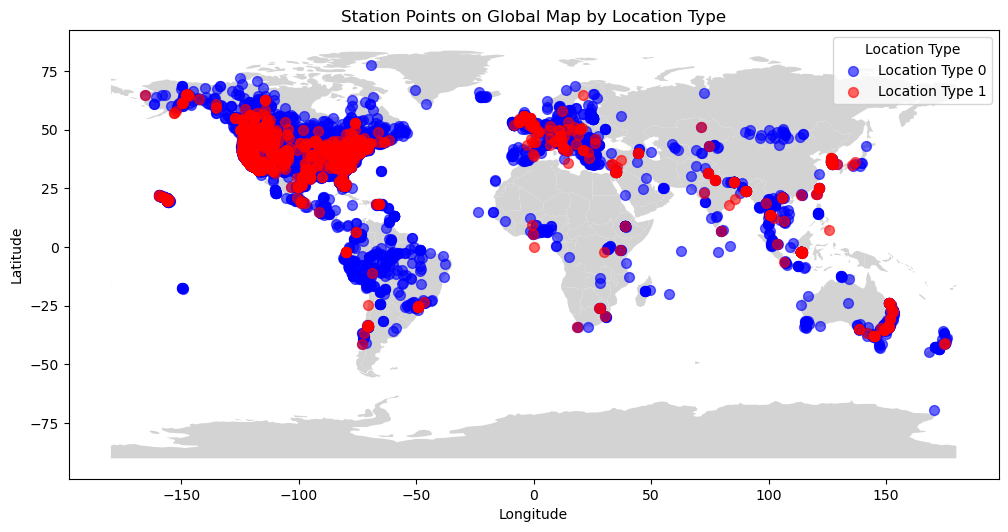

In [5]:
# Load a base map of the world
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Define colors for location types
colors = {0: 'blue', 1: 'red'}

# Plot the base map
fig, ax = plt.subplots(figsize=(12, 8))
world.plot(ax=ax, color='lightgrey')

# Plot sensor locations by location type
for location_type, color in colors.items():
    subset = gdf[gdf['location_type'] == location_type]
    subset.plot(ax=ax, color=color, markersize=50, alpha=0.6, label=f'Location Type {location_type}')

# Add legend
plt.legend(title='Location Type')

# Add titles and labels
plt.title('Station Points on Global Map by Location Type')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

Total number of available sensors: 26841
Most recent sensor created on: 2024-08-27 15:54:11
Oldest sensor created on: 2016-02-04 01:21:31

Available sensors by position rating:
position_rating
2      202
1      332
4      374
3      433
0     5711
5    19789
Name: count, dtype: int64

Available sensors by location type (0 = outdoor, 1 = indoor):
location_type
0    20522
1     6319
Name: count, dtype: int64

Available sensors by the last time of year the server received data from the device:
last_seen
2021        4
2022        4
2023       14
2024    26819
Name: count, dtype: int64


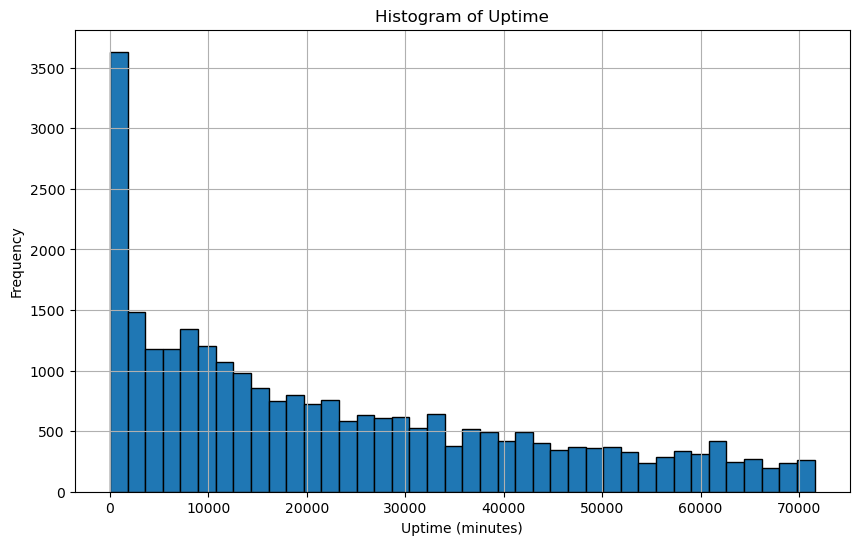

In [6]:
# Display the total number of available sensors
print("Total number of available sensors:", len(sensor_list))

# Display the most recent and oldest sensors based on the 'date_created' timestamp
print("Most recent sensor created on:", pd.to_datetime(max(sensor_list["date_created"]), unit='s').strftime('%Y-%m-%d %H:%M:%S'))
print("Oldest sensor created on:", pd.to_datetime(min(sensor_list["date_created"]), unit='s').strftime('%Y-%m-%d %H:%M:%S'))

# Display the available sensors by position rating, sorted by count
print("\nAvailable sensors by position rating:")
print(sensor_list['position_rating'].value_counts().sort_values())

# Display the available sensors by location type (0 = outdoor, 1 = indoor)
print("\nAvailable sensors by location type (0 = outdoor, 1 = indoor):")
print(sensor_list['location_type'].value_counts())

print("\nAvailable sensors by the last time of year the server received data from the device:")
print(pd.to_datetime(sensor_list['last_seen'], unit='s').dt.strftime('%Y').value_counts().sort_values())

# Create histogram of the 'uptime' column
plt.figure(figsize=(10, 6))
plt.hist(sensor_list['uptime'], bins=40, edgecolor='black')
plt.title('Histogram of Uptime')
plt.xlabel('Uptime (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

To do list: 
1. do we need sensors that is not in Jay's sensor list?
    - Jay's number of sensors are about 26000. Do we care about matching the current sensors with already downloaded sensors as much as possible or should we download available sensors and match it later?
    - also, based on jay's code, seems like he downloaded only us_indoor sensors data? is that correct? I thought we want to download all sensors across globally?

    - **Answer**: We don’t want to duplicate downloading data Jay already downloaded but we do want to download any available sensor data even if that sensor is not in Jay’s dataset (eg if it came online only recently). Also you’re right both that we want all sensors and that Jay started on US indoor. That was just a way for Jay to order the downloads he was ultimately planning on downloading everything just picked US indoor as the first group and then never got around to other groups.

2. do we need sensors whose position rating is doubtful? 

    - **Answer**: I think we can ignore position_rating for now and download everything. From reading about it that variable sounds like a potentially unreliable measure of position accuracy.
 
3. do we need sensors who stopped communicating to the PA prior years to 2024?

    - **Answer**: Yes in general we want all data from sensors even if they stopped communicating before 2024. That being said I think we can set some filter for minimum time online. Like maybe we only include sensors that were/are online for at least 180 days (~6 months). I don’t think we need to worry about monitors with only a few days of data available. I think we can check this from diff between first_seen and last_seen. Doesn’t need to be perfect.

4. data we have runs from Jan 1, 2021 to Dec 31, 2023. 

(From Jay's work) Prioritization of PA: 

- indoor US
- outdoor US 
- indoor international
- outdoor international

Variable we want: 
- ‘pm2.5_atm_a’
- ‘pm2.5_atm_b’
- ‘pm2.5_cf_1_a’
- ‘pm2.5_cf_1_b’
- ‘humidity’
- ‘temperature’

In [7]:
def get_sensors(us_indoor=True):
    """Retrieve sensor indexes based on whether they are indoor or not."""
    # Get list of us_indoor sensors
    us_indoor_sensors = pd.read_csv("data/input_data/supporting_data_files/indoor_us.csv")
    us_indoor_sensorlist = us_indoor_sensors['sensor_index'].tolist()
    
    if us_indoor:
        return us_indoor_sensorlist  # Return indoor sensors
    else:
        # Get the list of all sensors
        all_sensors = pd.read_csv('sensors_list.csv')
        all_sensorslist = all_sensors["sensor_index"].tolist()
        # Exclude us_indoor sensors from the complete list
        # non_us_indoor_sensors = [sensor for sensor in all_sensorslist if sensor not in us_indoor_sensorlist]
        return all_sensorslist  # Return all sensors

In [8]:
def create_pa_datelist(average_time, bdate, edate):
    """Create a list of date ranges for the historical data period."""
    
    # Dates of Historical Data period
    begindate = datetime.fromisoformat(bdate)
    enddate = datetime.fromisoformat(edate)
    
    # Download days based on average
    if average_time == 60:
        datelist = pd.date_range(begindate, enddate, freq='14d')  # 14 days of data
    else:
        datelist = pd.date_range(begindate, enddate, freq='5d')   # 5 days of data

    # Reverse to get data from end date to start date
    datelist = datelist.tolist()
    datelist.reverse()
    
    # Convert to required format
    date_list = [dt.strftime('%Y-%m-%dT%H:%M:%SZ') for dt in datelist]
    
    return date_list

In [41]:
def get_historicaldata(sensors_list, bdate, edate, average_time):
    """Download historical data for given sensors."""
    
    print(sensors_list)
    
    # Historical API URL: for multiple sensors
    root_api_url = 'https://api.purpleair.com/v1/sensors/'
    
    # Average time parameter for API
    average_api = f'&average={average_time}'
    
    # Create the fields API URL
    fields_list = ['pm2.5_atm_a', 'pm2.5_atm_b', 'pm2.5_cf_1_a', 'pm2.5_cf_1_b', 'humidity', 'temperature']
    fields_api_url = '&fields=' + '%2C'.join(fields_list)
    
    print("CHECK POINT 1:")
    print(fields_api_url)
    
    # Retrieve sensor index for us_indoor
    us_indoor_sensors = get_sensors(us_indoor=True)

    print("CHECK POINT 2:")
    print(us_indoor_sensors)
    
    # Generate date list for all sensors
    date_list = create_pa_datelist(average_time, bdate, edate)
    
    print("CHECK POINT 3:")
    print(date_list)
    
    # Generate date list to skip data (from 2021-01-01 to 2023-12-31)
    check_datelist = create_pa_datelist(average_time, '2021-01-01T00:00:00+00:00', '2023-12-31T00:00:00+00:00')
    
    print("CHECK POINT 4:")
    print(date_list)
    
    len_datelist = len(date_list) - 1
    
    
    # Process each sensor
    for sensor in sensors_list:
        
        hist_api_url = root_api_url + f'{sensor}/history/csv?api_key={key_read}'
            
        # Create start and end date API URL
        for index, date in enumerate(date_list):
            
            time.sleep(sleep_seconds)  # Throttle API requests
            
            if index < len_datelist:
                
                # Skip if sensor is in us_indoor and the date is in 2021-2023
                if sensor in us_indoor_sensors and min(check_datelist) <= date <= max(check_datelist):
                    print(f"Skipping download for {sensor} from {date_list[index+1]} to {date} (us_indoor sensor)")
                    continue

                # Download data for PA
                print(f'Downloading for PA: {sensor} for Dates: {date_list[index+1]} and {date}.')
                dates_api_url = f'&start_timestamp={date_list[index+1]}&end_timestamp={date}'
                
                print("CHECK POINT 5:")
                print(dates_api_url)
                
                api_url = hist_api_url + dates_api_url + average_api + fields_api_url
                
                print("CHECK POINT 6:")
                print(api_url)
                
                try:
                    response = requests.get(api_url)
                    response.raise_for_status()  # Raises HTTPError for bad responses
                    
                except requests.exceptions.RequestException as e:
                    # Handle request exceptions
                    print(f"Request failed for URL {api_url}: {e}")
                    continue  # Skip to next sensor/date
                
                try:
                    assert response.status_code == requests.codes.ok
                
                    # Creating a Pandas DataFrame
                    df = pd.read_csv(StringIO(response.text), sep=",", header=0)
                    
                except AssertionError:
                    # Handle assertion errors specifically
                    print(f"Bad status code for URL {api_url}. Status code: {response.status_code}")
                    df = pd.DataFrame()
                except pd.errors.EmptyDataError:
                    # Handle cases where the CSV is empty or unreadable
                    print(f"CSV data is empty or invalid for URL {api_url}")
                    df = pd.DataFrame()
                except Exception as e:
                    # Handle any other unexpected errors
                    print(f"An unexpected error occurred: {e}")
                    df = pd.DataFrame()
                
                if df.empty:
                    print('------------- No Data Available -------------')
                else:
                    # Adding Sensor Index/ID (Optional)
                    # df['id'] = sensor
                    
                    # Dropping duplicate rows
                    df = df.drop_duplicates(subset=None, keep='first', inplace=False)
                    df['time_stamp'] = pd.to_datetime(df['time_stamp'])
                    df = df.sort_values(by='time_stamp')
            
                    # Writing to Postgres Table (Optional)
                    # If you don't want to save to PostgreSQL, comment out this line
                    # df.to_sql('tablename', con=engine, if_exists='append', index=False)
                    
                    # Writing to CSV file
                    folderpath = 'data'  # Specifyfolder path
                    
                    out_begin_date = datetime.strptime(date_list[index+1], "%Y-%m-%dT%H:%M:%S%z").strftime("%Y_%m_%d") # format year_month_day
                    out_end_date = datetime.strptime(date, "%Y-%m-%dT%H:%M:%S%z").strftime("%Y_%m_%d") # format year_month_day
                    
                    filename = f'{folderpath}/sensorsID_{sensor}_{out_begin_date}_{out_end_date}.csv'
                    df.to_csv(filename, index=False, header=True)
                

In [42]:
# Data download period
from datetime import datetime

bdate = '2021-01-01T00:00:00+00:00' 
edate = '2021-01-06T00:00:00+00:00'

# edate = datetime.now().strftime('%Y-%m-%d') + 'T00:00:00+00:00'
# sensors_list = get_sensors(us_indoor=False)
# sample_sensors = [131255, 131365, 469, 53, 77, 182]
sample_sensors = [131255, 182]
result = get_historicaldata(sensors_list=sample_sensors, bdate= bdate, edate=edate, average_time=10)

[131255, 182]
CHECK POINT 1:
&fields=pm2.5_atm_a%2Cpm2.5_atm_b%2Cpm2.5_cf_1_a%2Cpm2.5_cf_1_b%2Chumidity%2Ctemperature
CHECK POINT 2:
[131255, 131365, 469, 131615, 131853, 820, 1004, 132135, 132197, 132469, 132481, 132763, 132839, 132841, 132853, 132929, 132951, 133047, 133131, 133251, 133283, 133373, 133497, 133519, 133666, 133664, 2624, 2628, 133728, 133736, 133742, 133740, 133750, 133768, 133778, 133868, 133878, 133880, 133896, 133942, 133964, 3011, 134084, 134092, 134102, 134104, 134112, 134120, 134128, 134140, 134150, 3118, 134252, 3253, 134366, 134370, 134374, 134382, 134380, 134388, 134398, 134396, 134400, 3497, 134722, 134746, 134758, 134760, 134772, 134806, 134814, 134894, 3862, 3882, 134966, 135004, 135012, 135016, 135020, 3951, 135024, 135030, 135028, 135044, 135050, 135080, 135132, 135156, 135196, 135214, 135222, 135220, 135226, 135230, 135380, 135416, 135438, 4368, 135440, 135492, 4450, 4476, 135548, 135558, 4551, 135624, 4635, 135720, 135734, 135736, 135756, 135766, 135772

In [43]:
result = pd.read_csv('data/sensorsID_182_2021_01_01_2021_01_06.csv')
result.tail()

,time_stamp,sensor_index,humidity,temperature,pm2.5_atm_a,pm2.5_atm_b,pm2.5_cf_1_a,pm2.5_cf_1_b
709,2021-01-05 23:10:00+00:00,182,72.4,49.0,0.180,0.788,0.180,0.788
710,2021-01-05 23:20:00+00:00,182,72.2,49.0,0.646,0.902,0.646,0.902
711,2021-01-05 23:30:00+00:00,182,72.6,49.0,0.638,0.950,0.638,0.950
712,2021-01-05 23:40:00+00:00,182,72.2,49.0,0.364,0.820,0.364,0.820
713,2021-01-05 23:50:00+00:00,182,72.6,48.6,0.478,0.958,0.478,0.958


The script will download each sensor for dates with five days of increments. Each download will have rows = 720 (144 for each day * 5 days increment) and columns = 8 (+2 as humidity and temperature 2 points each)

for each sensor: 
- point each day = 720*10 = 7200
- days total from 2021 to today = 3 years, 8 months and 5 days ago, which is 1,344 days
- total points per sensor = 1344 day * 7200 points per day = 9676800 point per sensor

For 26841 sensors:
- total points = 9676800 points per sensor * 26841 sensor = 2.59734989 * 10^11 = 259.73 billion points


| time_stamp        | sensor_index | humidity | temperature | pm2.5_atm_a | pm2.5_atm_b | pm2.5_cf_1_a | pm2.5_cf_1_b |
|-------------------|--------------|----------|-------------|-------------|-------------|--------------|--------------|
| 3/1/2023 0:00     | 15237        | 37       | 72.6        | 0.666       | 0.418       | 0.666        | 0.418        |
| 3/1/2023 0:10     | 15237        | 37       | 72          | 0.496       | 0.340       | 0.496        | 0.340        |


### To do list (sep 5, 2024): 

- i don't want to download data that RA did
    - us indoor from 2021 jan 1 to 2023 dec 31
- first get all sensor index that is in us indoor
- secod get all sensor index that is not us indoor (outside of us indoor)

1. Get Sensors:
    - `get_sensors()` retrieves sensor indexes based on whether they are part of us_indoor or not. 
2. Determine Date Ranges:
    - If the sensor is in `us_indoor` and the date range is from `January 1, 2021`, to `December 31, 2023`, skip the download.
3. Download Data:
    - For sensors not in the `us_indoor` category or for dates outside the specified range, proceed with the download logic.
4. Update Download Records:
    - After downloading data, the last downloaded date is updated to ensure that the next run continues from where it left off.

### to do list (sep 6, 2024)

1. Create download_records: begindate, and lastdate per sensor?
2. After download sensor data update the download_records
2. Post data to cloud server SQL
2. Retreat the data and rewrite and rbind the data
3. Post back to cloud server SQL?

